# import和全局变量

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

import random

from tqdm.auto import tqdm

from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)
torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 数据加载

In [2]:
data_root_dir = 'data'

Trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Resize([224, 224]),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                           ])

# 加载数据集
train_data = datasets.CIFAR10(
    root=data_root_dir, 
    train=True, 
    download=False, 
    transform=Trans
)

test_data = datasets.CIFAR10(
    root=data_root_dir,
    train=False,
    download=False,
    transform=Trans
)

# 划分训练集和验证集
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# 训练集数据增强
augmentation = transforms.Compose([#transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomCrop(32, padding=4),
                                   Trans
                                   ])
train_data.dataset.transform = augmentation


# 创建数据加载器
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, 
                                               num_workers=16, pin_memory=True, prefetch_factor=4, persistent_workers=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, 
                                             num_workers=16, pin_memory=True, prefetch_factor=4, persistent_workers=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [16]:
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 40000
验证集大小: 10000
测试集大小: 10000


In [17]:
image, label = train_data[0]

In [18]:
image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([224, 224, 3])


Text(0.5, 1.0, 'airplane')

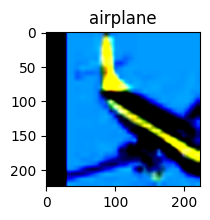

In [19]:
image = image.transpose(0, 2).transpose(0, 1)
label_map = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"Image shape: {image.shape}")
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.title(label_map[label])

In [7]:
for batch, (X, y) in enumerate(train_dataloader):
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


# 功能函数

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = 0.0

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def val_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    val_loss, val_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            val_pred = model(X)
            
            # 2. Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(y_true=y,
                y_pred=val_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
        return val_loss, val_acc

def train(model, loss, optimizer, train_dataloader, val_dataloader, 
          scheduler=None, 
          num_epochs=10, 
          device=device, 
          early_stopper=EarlyStopper(patience=8, min_delta=0.02)):
    def convert(array):
        return [i.detach().cpu().numpy() for i in array]
    
    model.to(device)
    #fig, axs = plt.subplots(2, figsize=(4, 3*2))
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss, train_acc = train_step(model, train_dataloader, loss, optimizer, accuracy_fn, device)
        val_loss, val_acc = val_step(val_dataloader, model, loss, accuracy_fn, device)
        scheduler.step()
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc / 100)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc / 100)
        if early_stopper.early_stop(val_acc):
            print("Early stopping at epoch", epoch+1)
            break

    print("Finished training")
    plt.plot(range(1,len(train_loss_list)+1), convert(train_loss_list), label="train_loss")
    plt.plot(range(1,len(val_loss_list)+1), convert(val_loss_list), label="val_loss")
    plt.plot(range(1,len(val_acc_list)+1), val_acc_list, linestyle='--',label="val_acc")
    plt.legend()
    #axs[1].plot(range(1,num_epochs+1), train_acc_list, linestyle='-',label="train_acc")
    #axs[1].legend()
    
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.kaiming_uniform_(module.weight)

def layer_summary(model, X_shape):
    X = torch.randn(*X_shape)
    for layer in model.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



# 模型训练


## 线性分类
### 定义

In [7]:
class FlatternModel(nn.Module):
    def __init__(self, input_size=3*32*32, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        return self.net(x)
    

### 训练

Epoch 1
-------------------------------
Train loss: 4.29119 | Train accuracy: 10.06%
Validation loss: 2.30840 | Validation accuracy: 9.95%

Epoch 2
-------------------------------
Train loss: 2.31562 | Train accuracy: 10.05%
Validation loss: 2.31393 | Validation accuracy: 10.29%

Epoch 3
-------------------------------
Train loss: 2.31553 | Train accuracy: 10.01%
Validation loss: 2.30567 | Validation accuracy: 10.29%

Epoch 4
-------------------------------
Train loss: 2.31568 | Train accuracy: 10.03%
Validation loss: 2.31452 | Validation accuracy: 9.95%

Epoch 5
-------------------------------
Train loss: 2.31471 | Train accuracy: 9.82%
Validation loss: 2.31339 | Validation accuracy: 9.68%

Epoch 6
-------------------------------
Train loss: 2.31708 | Train accuracy: 10.19%
Validation loss: 2.32653 | Validation accuracy: 9.51%

Epoch 7
-------------------------------
Train loss: 2.31593 | Train accuracy: 9.71%
Validation loss: 2.31766 | Validation accuracy: 10.14%

Epoch 8
-----------

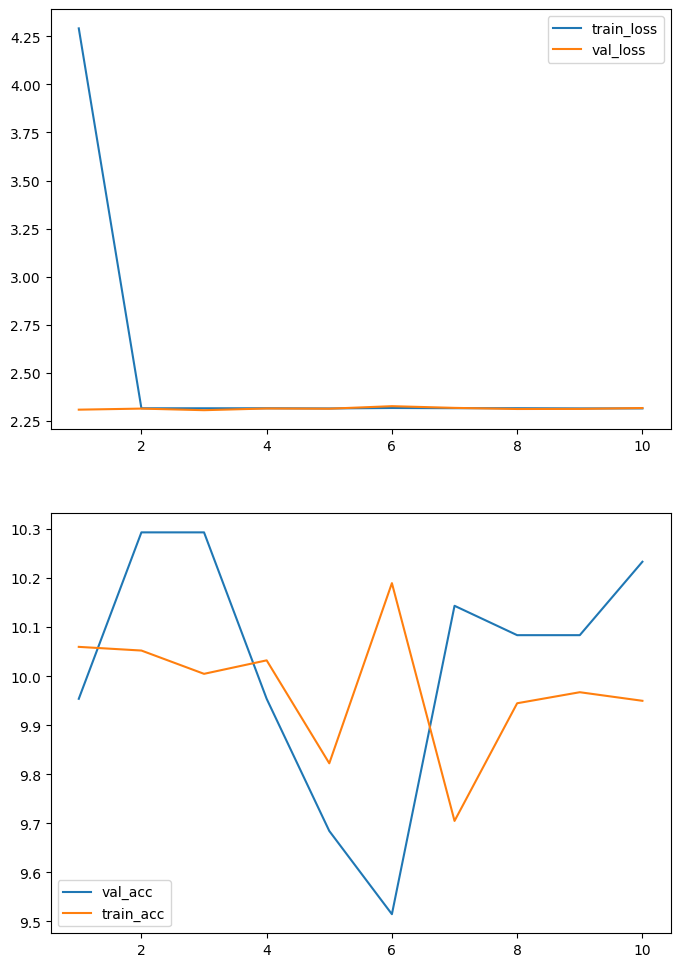

In [16]:
%%time
model = FlatternModel()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

train(model, loss_fn, optimizer, train_dataloader, val_dataloader, num_epochs=10, device=device)

## LeNet
### 最早的尝试
#### 定义

In [14]:
class LeNet(nn.Module): 
    """The LeNet-5 model."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        init_cnn(self.net)
    
    def forward(self, X):
        return self.net(X)
    
model = LeNet()
layer_summary(model, (1, 3, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


e:\anaconda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### 训练

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 2.30056 | Train accuracy: 11.62%
Validation loss: 2.29262 | Validation accuracy: 15.73%

Epoch 2
-------------------------------
Train loss: 2.13812 | Train accuracy: 20.82%
Validation loss: 1.99636 | Validation accuracy: 26.41%

Epoch 3
-------------------------------
Train loss: 1.89703 | Train accuracy: 31.51%
Validation loss: 1.82957 | Validation accuracy: 33.42%

Epoch 4
-------------------------------
Train loss: 1.78164 | Train accuracy: 36.37%
Validation loss: 1.81556 | Validation accuracy: 33.70%

Epoch 5
-------------------------------
Train loss: 1.69633 | Train accuracy: 39.25%
Validation loss: 1.66429 | Validation accuracy: 40.01%

Epoch 6
-------------------------------
Train loss: 1.61452 | Train accuracy: 42.08%
Validation loss: 1.62729 | Validation accuracy: 41.20%

Epoch 7
-------------------------------
Train loss: 1.54663 | Train accuracy: 44.56%
Validation loss: 1.54293 | Validation accuracy: 44.62%

Epoch 8
-----

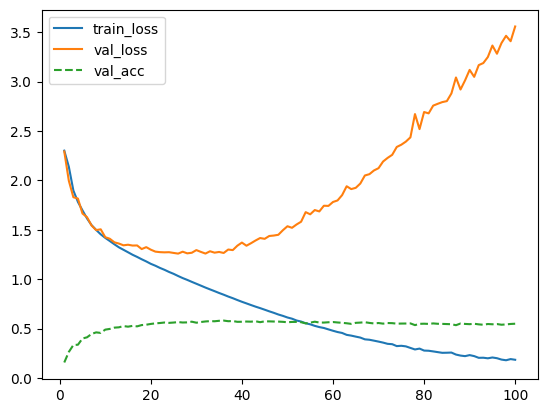

In [15]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=100, device=device)

### 添加了BatchNorm和数据增强

In [41]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class LeNet_with_norm(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        init_cnn(self.net)
    
    def forward(self, X):
        return self.net(X)
    
model = LeNet_with_norm()
X = torch.randn(1, 3, 32, 32)
layer_summary(model, X.shape)

Sequential output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Sequential output shape:	 torch.Size([1, 6, 16, 16])
AvgPool2d output shape:	 torch.Size([1, 6, 8, 8])
Sequential output shape:	 torch.Size([1, 6, 8, 8])
AvgPool2d output shape:	 torch.Size([1, 6, 4, 4])
Flatten output shape:	 torch.Size([1, 96])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 2.23751 | Train accuracy: 16.68%
Validation loss: 2.17876 | Validation accuracy: 20.07%

Epoch 2
-------------------------------
Train loss: 2.12535 | Train accuracy: 22.09%
Validation loss: 2.09853 | Validation accuracy: 23.58%

Epoch 3
-------------------------------
Train loss: 2.03220 | Train accuracy: 26.60%
Validation loss: 2.04043 | Validation accuracy: 26.73%

Epoch 4
-------------------------------
Train loss: 1.95747 | Train accuracy: 29.39%
Validation loss: 1.94420 | Validation accuracy: 30.40%

Epoch 5
-------------------------------
Train loss: 1.90240 | Train accuracy: 31.70%
Validation loss: 1.87428 | Validation accuracy: 33.41%

Epoch 6
-------------------------------
Train loss: 1.87106 | Train accuracy: 33.16%
Validation loss: 1.86206 | Validation accuracy: 33.56%

Epoch 7
-------------------------------
Train loss: 1.84572 | Train accuracy: 33.93%
Validation loss: 1.81660 | Validation accuracy: 34.38%

Epoch 8
-----

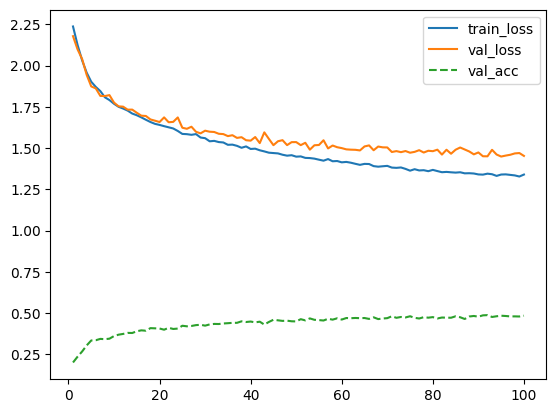

In [42]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=100, device=device)

### 保存

In [16]:
MODEL_NAME = "lenet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

## ResNet
### 定义
模仿了ResNet18的结构，但是ResNet18是在ImageNet上训练的，CIFAR-10的分辨率低很多，所以第一个 $7*7$ 卷积换成了 $5*5$ 的。

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = nn.Dropout2d(0.1)(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
        
        self.net.add_module("last", nn.Sequential(      
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

        init_cnn(self.net)

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResidualBlock(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(ResidualBlock(num_channels))
        return nn.Sequential(*blk)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def forward(self, X):
        return self.net(X)
    
model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
layer_summary(model, (1, 3, 32, 32))

Sequential output shape:	 torch.Size([1, 64, 9, 9])
Sequential output shape:	 torch.Size([1, 64, 9, 9])
Sequential output shape:	 torch.Size([1, 128, 5, 5])
Sequential output shape:	 torch.Size([1, 256, 3, 3])
Sequential output shape:	 torch.Size([1, 512, 2, 2])
Sequential output shape:	 torch.Size([1, 10])


e:\anaconda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 训练

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.88174 | Train accuracy: 28.38%
Validation loss: 1.64931 | Validation accuracy: 39.13%

Epoch 2
-------------------------------
Train loss: 1.60362 | Train accuracy: 40.09%
Validation loss: 1.48545 | Validation accuracy: 44.71%

Epoch 3
-------------------------------
Train loss: 1.43266 | Train accuracy: 47.74%
Validation loss: 1.39819 | Validation accuracy: 48.85%

Epoch 4
-------------------------------
Train loss: 1.30400 | Train accuracy: 52.68%
Validation loss: 1.29405 | Validation accuracy: 53.31%

Epoch 5
-------------------------------
Train loss: 1.22185 | Train accuracy: 56.12%
Validation loss: 1.20200 | Validation accuracy: 57.75%

Epoch 6
-------------------------------
Train loss: 1.13787 | Train accuracy: 59.42%
Validation loss: 1.23389 | Validation accuracy: 57.24%

Epoch 7
-------------------------------
Train loss: 1.08515 | Train accuracy: 61.45%
Validation loss: 1.15780 | Validation accuracy: 59.70%

Epoch 8
-----

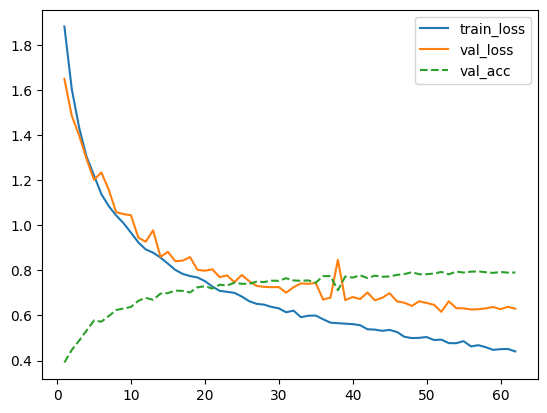

In [22]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, num_epochs=100, device=device)

### 更大的Dropout

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = nn.Dropout2d(0.5)(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
        
        self.net.add_module("last", nn.Sequential(      
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

        init_cnn(self.net)

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResidualBlock(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(ResidualBlock(num_channels))
        return nn.Sequential(*blk)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def forward(self, X):
        return self.net(X)
    
model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
#layer_summary(model, (1, 3, 32, 32))

e:\anaconda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.98236 | Train accuracy: 25.23%
Validation loss: 1.76689 | Validation accuracy: 33.52%

Epoch 2
-------------------------------
Train loss: 1.70604 | Train accuracy: 36.10%
Validation loss: 1.65292 | Validation accuracy: 38.13%

Epoch 3
-------------------------------
Train loss: 1.58408 | Train accuracy: 41.30%
Validation loss: 1.55848 | Validation accuracy: 42.06%

Epoch 4
-------------------------------
Train loss: 1.51648 | Train accuracy: 44.16%
Validation loss: 1.51834 | Validation accuracy: 43.88%

Epoch 5
-------------------------------
Train loss: 1.47035 | Train accuracy: 45.94%
Validation loss: 1.45967 | Validation accuracy: 46.11%

Epoch 6
-------------------------------
Train loss: 1.42046 | Train accuracy: 47.94%
Validation loss: 1.39665 | Validation accuracy: 48.52%

Epoch 7
-------------------------------
Train loss: 1.38767 | Train accuracy: 49.71%
Validation loss: 1.34440 | Validation accuracy: 50.89%

Epoch 8
-----

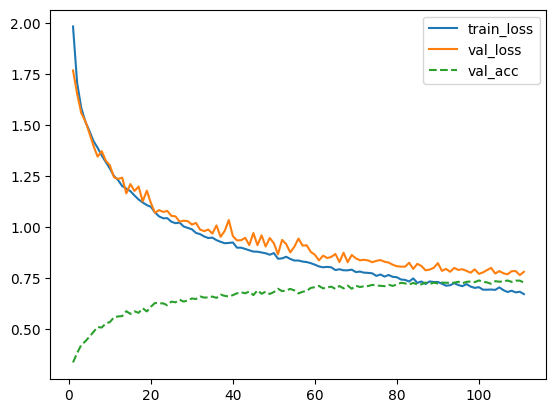

In [35]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, num_epochs=200, device=device, early_stopper=EarlyStopper(patience=10, min_delta=0.02))

### 保存

In [35]:
MODEL_NAME = "ResNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

## DenseNet
### 定义

In [4]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels // 8, kernel_size=1),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
                 num_classes=10):
        super(DenseNet, self).__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_block{i+1}', DenseBlock(num_convs,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        init_cnn(self.net)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7 * 7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def forward(self, X):
        return self.net(X)

model = DenseNet(arch=(6, 12, 32, 32))
X = torch.randn(1, 3, 224, 224)
layer_summary(model, X.shape)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 46, 46])
DenseBlock output shape:	 torch.Size([1, 256, 46, 46])
Sequential output shape:	 torch.Size([1, 128, 23, 23])
DenseBlock output shape:	 torch.Size([1, 512, 23, 23])
Sequential output shape:	 torch.Size([1, 256, 11, 11])
DenseBlock output shape:	 torch.Size([1, 1280, 11, 11])
Sequential output shape:	 torch.Size([1, 640, 5, 5])
DenseBlock output shape:	 torch.Size([1, 1664, 5, 5])
Sequential output shape:	 torch.Size([1, 10])


### 训练

In [5]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, num_epochs=200, 
      device=device, early_stopper=EarlyStopper(patience=10, min_delta=0.02))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.87600 | Train accuracy: 30.79%


  0%|          | 1/200 [03:18<10:58:25, 198.52s/it]

Validation loss: 1.62008 | Validation accuracy: 38.85%

Epoch 2
-------------------------------
Train loss: 1.61824 | Train accuracy: 40.05%


  1%|          | 2/200 [06:19<10:20:24, 188.00s/it]

Validation loss: 1.47953 | Validation accuracy: 45.02%

Epoch 3
-------------------------------
Train loss: 1.42962 | Train accuracy: 47.71%


  2%|▏         | 3/200 [09:20<10:07:36, 185.06s/it]

Validation loss: 1.35743 | Validation accuracy: 51.35%

Epoch 4
-------------------------------
Train loss: 1.29079 | Train accuracy: 53.37%


  2%|▏         | 4/200 [12:23<10:00:59, 183.98s/it]

Validation loss: 1.22650 | Validation accuracy: 55.97%

Epoch 5
-------------------------------
Train loss: 1.17937 | Train accuracy: 57.78%


  2%|▎         | 5/200 [15:23<9:54:19, 182.87s/it] 

Validation loss: 1.17695 | Validation accuracy: 57.43%

Epoch 6
-------------------------------
Train loss: 1.09594 | Train accuracy: 60.82%


  3%|▎         | 6/200 [18:24<9:48:23, 181.98s/it]

Validation loss: 1.07446 | Validation accuracy: 62.89%

Epoch 7
-------------------------------
Train loss: 1.02829 | Train accuracy: 63.43%


  4%|▎         | 7/200 [21:25<9:44:13, 181.63s/it]

Validation loss: 1.00026 | Validation accuracy: 64.05%

Epoch 8
-------------------------------
Train loss: 0.96757 | Train accuracy: 66.02%


  4%|▍         | 8/200 [24:25<9:39:36, 181.13s/it]

Validation loss: 0.96695 | Validation accuracy: 65.94%

Epoch 9
-------------------------------
Train loss: 0.91688 | Train accuracy: 67.60%


  4%|▍         | 9/200 [27:24<9:35:17, 180.72s/it]

Validation loss: 0.90737 | Validation accuracy: 68.09%

Epoch 10
-------------------------------
Train loss: 0.87131 | Train accuracy: 69.12%


  5%|▌         | 10/200 [30:24<9:31:05, 180.34s/it]

Validation loss: 0.91435 | Validation accuracy: 68.12%

Epoch 11
-------------------------------
Train loss: 0.81958 | Train accuracy: 71.27%


  6%|▌         | 11/200 [33:24<9:27:21, 180.12s/it]

Validation loss: 0.87777 | Validation accuracy: 69.77%

Epoch 12
-------------------------------
Train loss: 0.78578 | Train accuracy: 72.40%


  6%|▌         | 12/200 [36:23<9:24:06, 180.03s/it]

Validation loss: 0.86592 | Validation accuracy: 69.88%

Epoch 13
-------------------------------
Train loss: 0.75751 | Train accuracy: 73.53%


  6%|▋         | 13/200 [39:21<9:18:42, 179.27s/it]

Validation loss: 0.77131 | Validation accuracy: 72.95%

Epoch 14
-------------------------------
Train loss: 0.73186 | Train accuracy: 74.64%


  7%|▋         | 14/200 [42:20<9:15:24, 179.16s/it]

Validation loss: 0.81179 | Validation accuracy: 72.15%

Epoch 15
-------------------------------
Train loss: 0.71375 | Train accuracy: 75.19%


  8%|▊         | 15/200 [45:22<9:14:52, 179.96s/it]

Validation loss: 0.72214 | Validation accuracy: 74.77%

Epoch 16
-------------------------------
Train loss: 0.68830 | Train accuracy: 75.89%


  8%|▊         | 16/200 [48:20<9:10:07, 179.39s/it]

Validation loss: 0.71772 | Validation accuracy: 75.23%

Epoch 17
-------------------------------
Train loss: 0.67171 | Train accuracy: 76.64%


  8%|▊         | 17/200 [51:18<9:06:10, 179.07s/it]

Validation loss: 0.71277 | Validation accuracy: 74.98%

Epoch 18
-------------------------------
Train loss: 0.66041 | Train accuracy: 76.95%


  9%|▉         | 18/200 [54:16<9:01:58, 178.67s/it]

Validation loss: 0.70354 | Validation accuracy: 75.96%

Epoch 19
-------------------------------
Train loss: 0.64244 | Train accuracy: 77.53%


 10%|▉         | 19/200 [57:18<9:01:46, 179.59s/it]

Validation loss: 0.64747 | Validation accuracy: 77.82%

Epoch 20
-------------------------------
Train loss: 0.63138 | Train accuracy: 77.89%


 10%|█         | 20/200 [1:00:18<8:59:36, 179.87s/it]

Validation loss: 0.64124 | Validation accuracy: 77.59%

Epoch 21
-------------------------------
Train loss: 0.60424 | Train accuracy: 78.98%


 10%|█         | 21/200 [1:03:16<8:55:10, 179.39s/it]

Validation loss: 0.68194 | Validation accuracy: 76.22%

Epoch 22
-------------------------------
Train loss: 0.58336 | Train accuracy: 79.50%


 11%|█         | 22/200 [1:06:15<8:51:11, 179.05s/it]

Validation loss: 0.67778 | Validation accuracy: 76.44%

Epoch 23
-------------------------------
Train loss: 0.57122 | Train accuracy: 80.07%


 12%|█▏        | 23/200 [1:09:16<8:50:42, 179.90s/it]

Validation loss: 0.61730 | Validation accuracy: 78.38%

Epoch 24
-------------------------------
Train loss: 0.56621 | Train accuracy: 80.15%


 12%|█▏        | 24/200 [1:12:20<8:50:53, 180.99s/it]

Validation loss: 0.64591 | Validation accuracy: 77.73%

Epoch 25
-------------------------------
Train loss: 0.55684 | Train accuracy: 80.26%


 12%|█▎        | 25/200 [1:15:19<8:46:18, 180.45s/it]

Validation loss: 0.63069 | Validation accuracy: 77.93%

Epoch 26
-------------------------------
Train loss: 0.54118 | Train accuracy: 81.03%


 13%|█▎        | 26/200 [1:18:19<8:43:08, 180.40s/it]

Validation loss: 0.62693 | Validation accuracy: 78.63%

Epoch 27
-------------------------------
Train loss: 0.53355 | Train accuracy: 81.31%


 14%|█▎        | 27/200 [1:21:21<8:40:55, 180.67s/it]

Validation loss: 0.64692 | Validation accuracy: 78.53%

Epoch 28
-------------------------------
Train loss: 0.53149 | Train accuracy: 81.32%


 14%|█▍        | 28/200 [1:24:21<8:37:24, 180.49s/it]

Validation loss: 0.63818 | Validation accuracy: 78.13%

Epoch 29
-------------------------------
Train loss: 0.51269 | Train accuracy: 81.97%


 14%|█▍        | 29/200 [1:27:22<8:35:17, 180.80s/it]

Validation loss: 0.61012 | Validation accuracy: 79.34%

Epoch 30
-------------------------------
Train loss: 0.50654 | Train accuracy: 82.10%


 15%|█▌        | 30/200 [1:30:24<8:32:45, 180.97s/it]

Validation loss: 0.63979 | Validation accuracy: 78.28%

Epoch 31
-------------------------------
Train loss: 0.49021 | Train accuracy: 83.02%


 16%|█▌        | 31/200 [1:33:27<8:31:39, 181.65s/it]

Validation loss: 0.59059 | Validation accuracy: 79.92%

Epoch 32
-------------------------------
Train loss: 0.47974 | Train accuracy: 83.23%


 16%|█▌        | 32/200 [1:36:30<8:29:26, 181.94s/it]

Validation loss: 0.58668 | Validation accuracy: 80.40%

Epoch 33
-------------------------------
Train loss: 0.46533 | Train accuracy: 83.57%


 16%|█▋        | 33/200 [1:39:34<8:28:16, 182.62s/it]

Validation loss: 0.60189 | Validation accuracy: 78.98%

Epoch 34
-------------------------------
Train loss: 0.46859 | Train accuracy: 83.46%


 17%|█▋        | 34/200 [1:42:36<8:24:57, 182.52s/it]

Validation loss: 0.57237 | Validation accuracy: 80.32%

Epoch 35
-------------------------------
Train loss: 0.45743 | Train accuracy: 83.91%


 18%|█▊        | 35/200 [1:45:39<8:22:40, 182.79s/it]

Validation loss: 0.57014 | Validation accuracy: 80.45%

Epoch 36
-------------------------------
Train loss: 0.44459 | Train accuracy: 84.17%


 18%|█▊        | 36/200 [1:48:43<8:20:10, 182.99s/it]

Validation loss: 0.57727 | Validation accuracy: 80.45%

Epoch 37
-------------------------------
Train loss: 0.44578 | Train accuracy: 84.39%


 18%|█▊        | 37/200 [1:51:47<8:18:05, 183.35s/it]

Validation loss: 0.58281 | Validation accuracy: 80.43%

Epoch 38
-------------------------------
Train loss: 0.43725 | Train accuracy: 84.66%


: 

e:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.94129 | Train accuracy: 30.51%
Validation loss: 1.60267 | Validation accuracy: 40.51%

Epoch 2
-------------------------------
Train loss: 1.60692 | Train accuracy: 39.95%
Validation loss: 1.54355 | Validation accuracy: 43.33%

Epoch 3
-------------------------------
Train loss: 1.42265 | Train accuracy: 47.60%
Validation loss: 1.32748 | Validation accuracy: 52.20%

Epoch 4
-------------------------------
Train loss: 1.31530 | Train accuracy: 52.10%
Validation loss: 1.26671 | Validation accuracy: 54.47%

Epoch 5
-------------------------------
Train loss: 1.23048 | Train accuracy: 55.64%
Validation loss: 1.22543 | Validation accuracy: 56.33%

Epoch 6
-------------------------------
Train loss: 1.14537 | Train accuracy: 58.83%
Validation loss: 1.15599 | Validation accuracy: 58.59%

Epoch 7
-------------------------------
Train loss: 1.08919 | Train accuracy: 61.05%
Validation loss: 1.12573 | Validation accuracy: 60.04%

Epoch 8
-----

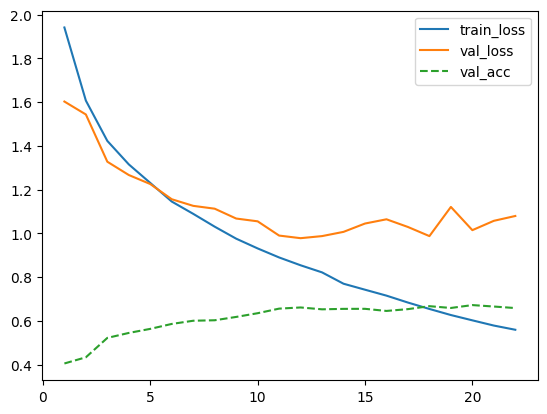

In [5]:
%%time
model = torchvision.models.densenet121(pretrained=False)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=50, device=device, early_stopper=EarlyStopper(patience=8, min_delta=0.02))

### 保存

In [12]:
MODEL_NAME = "DenseNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

# 评估

In [6]:
load_model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
MODEL_NAME = "ResNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
load_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loss = nn.CrossEntropyLoss()
val_step(test_dataloader, load_model, loss, accuracy_fn, device=device)

Validation loss: 0.60185 | Validation accuracy: 79.94%



(tensor(0.6019, device='cuda:0'), 79.94209265175719)